# Введение в нейронные сети

## Урок 2. Keras

1. Попробуйте обучить, нейронную сеть на Keras (рассмотренную на уроке) на датасете fashion_mnist с другими параметрами.
2. Какого результата вы добились от нейросети?
3. Что помогло вам улучшить её точность?
4. Поработайте с документацией Keras. Попробуйте найти полезные команды Keras, неразобранные на уроке.

In [1]:
from keras.datasets import fashion_mnist
from keras.utils.vis_utils import plot_model
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import itertools

%matplotlib inline

In [2]:
# Зафиксируем seed
tf.keras.utils.set_random_seed(
    142
)

In [3]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()
print(X_train.shape, X_test.shape)
print(y_train_labels.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,)


Label is 1


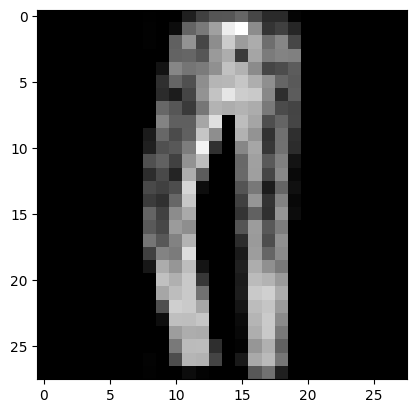

In [4]:
ind = np.random.randint(0, X_train.shape[0])
plt.imshow(X_train[ind], cmap='gray')
print(f'Label is {y_train_labels[ind]}')

Набор из 60 000 полутоновых изображений 28х28 серого цвета 10 категорий моды, а также тестовый набор из 10 000 изображений.<br>
Классовые метки:<br>
   * 0 - футболка/клубка<br>
   * 1 - Брюки<br>
   * 2 - Пуловер<br>
   * 3 - Платье<br>
   * 4 - Пальто<br>
   * 5 - Сандал<br>
   * 6 - Рубашка<br>
   * 7 - Кроссовок<br>
   * 8 - Сумка<br>
   * 9 - Ботинок

Конвертируем значения пикселей из вида от 0 до 255 в набор значений от 0 до 1.

In [5]:
X_train.min(), X_train.max()

(0, 255)

In [6]:
# Нормировка
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train.min(), X_train.max()

(0.0, 1.0)

In [7]:
# Вытягивание признаков
X_train = X_train.reshape((-1, 28 * 28))
X_test = X_test.reshape((-1, 28 * 28))

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

Передача данных для обучения нейросети

In [8]:
y_train_labels[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [9]:
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

### Подбор количества нейронов для двухслойной сети

Проверим качество в зависимости от числа нейронов в слое (для 2-х слойной сети).

In [10]:
%%time
results_num = pd.DataFrame()
n_nums = []
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []


for n_num in list(map(lambda x: 2**x, range(0,10))):
    
    n_nums.append(n_num)
    
    model = Sequential([
        Dense(98, input_shape=(28 * 28,), activation='relu'),
        Dense(n_num, activation='relu'),
        Dense(10, activation='sigmoid')
    ])

    model.summary()
    
    # Компиляция модели
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                    epochs=7,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test)
                    )
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=64)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=64)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)
    
    
results_num['n_num'] = n_nums
results_num['train_loss'] = train_losses
results_num['test_loss'] = test_losses
results_num['train_metric'] = train_metrics
results_num['test_metric'] = test_metrics
results_num.sort_values(by='test_metric', ascending=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 98)                76930     
                                                                 
 dense_1 (Dense)             (None, 1)                 99        
                                                                 
 dense_2 (Dense)             (None, 10)                20        
                                                                 
Total params: 77,049
Trainable params: 77,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
938/938 [==============================] - 2s 2ms/step - loss: 2.1364 - accuracy: 0.1853 - val_loss: 2.0474 - val_accuracy: 0.2101
Epoch 2/7
938/938 [==============================] - 1s 1ms/step - loss: 1.9965 - accuracy: 0.2195 - val_loss: 1.9501 - val_accuracy: 0.2316
Epoch 3/7
938/938 [===============

,n_num,train_loss,test_loss,train_metric,test_metric
9,512,0.417155,0.452825,0.854117,0.8417
7,128,0.417744,0.456136,0.854650,0.8409
8,256,0.417345,0.454040,0.853367,0.8397
4,16,0.418986,0.453671,0.854117,0.8393
5,32,0.419418,0.456163,0.851450,0.8384
6,64,0.417718,0.456047,0.854283,0.8384
3,8,0.452982,0.488716,0.844517,0.8329
2,4,0.598157,0.633277,0.803783,0.7923
1,2,0.883749,0.896468,0.661017,0.6609
0,1,1.710242,1.718145,0.348467,0.3448


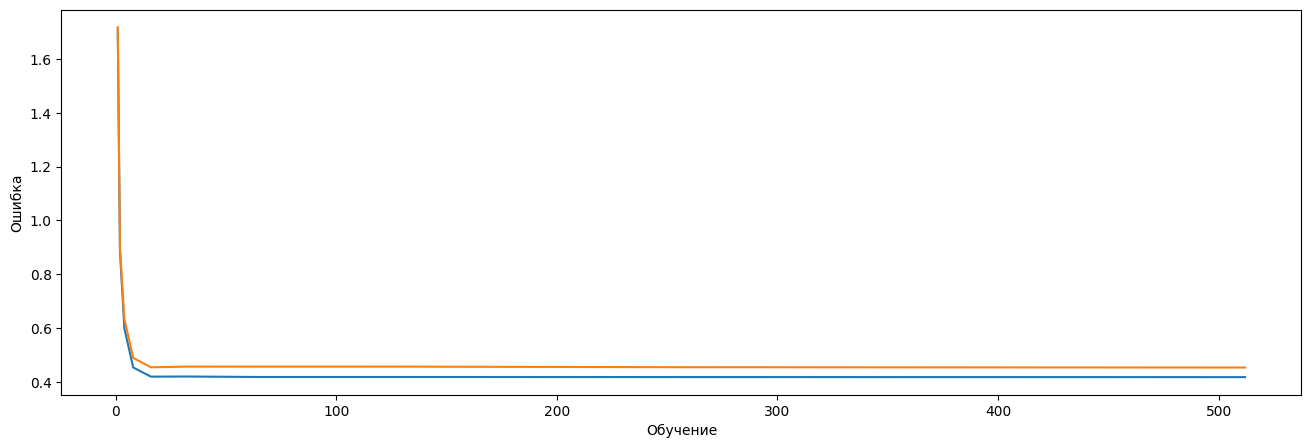

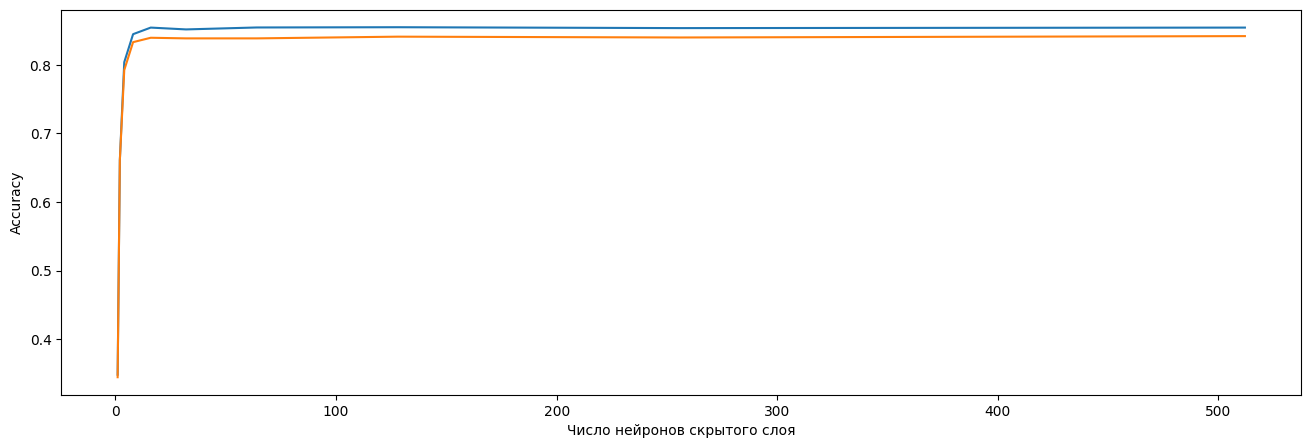

In [11]:
# Демонстрация полученных результатов
# Диаграмма точности в зависимости от обучения
plt.figure(figsize=(16, 5))
plt.plot(results_num['n_num'],results_num['train_loss'], label='train')
plt.plot(results_num['n_num'],results_num['test_loss'], label='test')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(results_num['n_num'],results_num['train_metric'], label='train')
plt.plot(results_num['n_num'],results_num['test_metric'], label='test')
plt.xlabel('Число нейронов скрытого слоя')
plt.ylabel('Accuracy')
plt.show()

Лучшее качество на тесте получилось при 512 нейронах.<br>
В общем тенденция такая: сначала, при увеличении числа нейронов скрытого слоя, качество росло, затем, начиная с некоторого количества (примерно 32), качество стало уменьшаться.

### Подбор количества слоёв

Проверим качество в зависимости от числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых параметров)

In [12]:
%%time
results_layers = pd.DataFrame()
n_nums = [] # число нейронов скрытых слоев
n_layers = [] # число скрытых слоев
n_pars = [] # число тренируемых параметров
train_losses = [] # ошибка на тренировочной выборке
test_losses = [] # ошибка на тестовой выборке
train_metrics = [] # accuracy на тренировочной выборке
test_metrics = [] # accuracy на тестовой выборке

# Базовый размер возьмем для двухслойной сети с 512 нейронами, и будем равняться на него
# Подберём количество нейронов так, чтобы количество параметров было примерно одинаково
k_dict = {2:512, 3:162, 5:101, 10:64}
for n in [2, 3, 5, 10]:
    
    k = k_dict[n]
    net_size = 64 * 785 + 65 * k + (n - 2) * (k + 1) * k + (k + 1) * 10
    n_nums.append(k) 
    n_pars.append(net_size)
    n_layers.append(n)
    
    model = Sequential()
    model.add(Dense(64, input_shape=(28 * 28,), activation='relu'))
    for i in range(n - 1):
        model.add(Dense(k, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))

    model.summary()
    
    # Компиляция модели
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                    epochs=7,
                    batch_size=64,
                    verbose=1,
                    validation_data=(X_test, y_test)
                    )
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=64)
    train_losses.append(train_loss)
    train_metrics.append(train_metric)
    test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=64)
    test_losses.append(test_loss)
    test_metrics.append(test_metric)
    
    
results_layers['n_layer'] = n_layers
results_layers['n_num'] = n_nums
results_layers['n_par'] = n_pars
results_layers['train_loss'] = train_losses
results_layers['test_loss'] = test_losses
results_layers['train_metric'] = train_metrics
results_layers['test_metric'] = test_metrics
results_layers.sort_values(by='test_metric', ascending=False)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 64)                50240     
                                                                 
 dense_31 (Dense)            (None, 512)               33280     
                                                                 
 dense_32 (Dense)            (None, 10)                5130      
                                                                 
Total params: 88,650
Trainable params: 88,650
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
938/938 [==============================] - 2s 2ms/step - loss: 1.0260 - accuracy: 0.6718 - val_loss: 0.6983 - val_accuracy: 0.7459
Epoch 2/7
938/938 [==============================] - 2s 2ms/step - loss: 0.5881 - accuracy: 0.8017 - val_loss: 0.5625 - val_accuracy: 0.8045
Epoch 3/7
938/938 [============

,n_layer,n_num,n_par,train_loss,test_loss,train_metric,test_metric
1,3,162,88806,0.414158,0.454414,0.852983,0.8385
0,2,512,88650,0.420551,0.457677,0.852867,0.8379
2,5,101,88731,0.411609,0.455114,0.851783,0.8366
3,10,64,88330,0.421071,0.474877,0.845617,0.8259


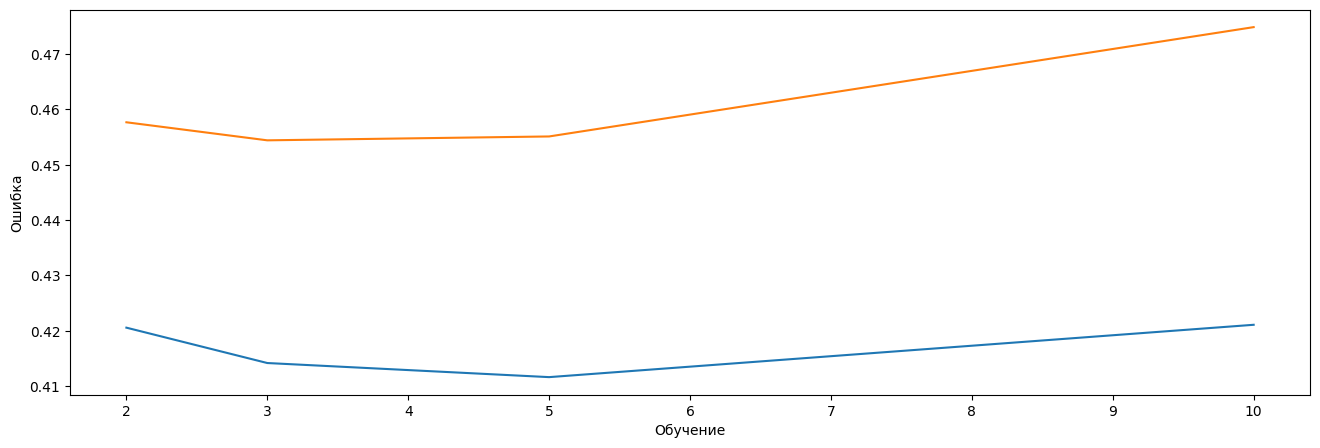

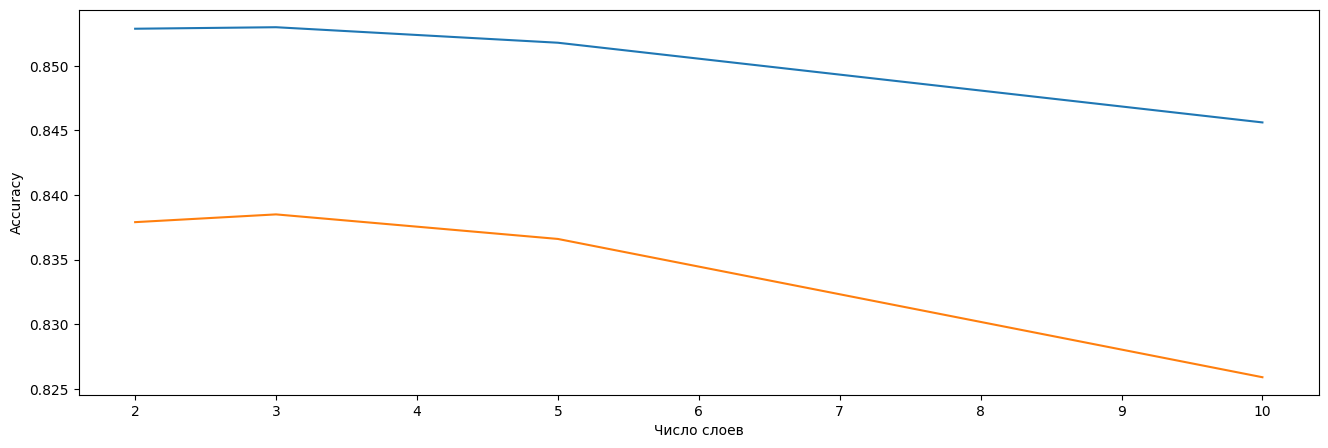

In [13]:
# Демонстрация полученных результатов
# Диаграмма точности в зависимости от обучения
plt.figure(figsize=(16, 5))
plt.plot(results_layers['n_layer'],results_layers['train_loss'], label='train')
plt.plot(results_layers['n_layer'],results_layers['test_loss'], label='test')
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(results_layers['n_layer'],results_layers['train_metric'], label='train')
plt.plot(results_layers['n_layer'],results_layers['test_metric'], label='test')
plt.xlabel('Число слоев')
plt.ylabel('Accuracy')
plt.show()

Лучшее качество получилось на 2 слоях с 512 нейронами.<br>
На 10 слоях качество прилично просело. Может быть это связано с тем, что количество нейронов скрытых слоев ниже, чтобы сохранить общее количество тренируемых параметров.

### Сохранение модели и оптимизаторы

Посмотрим работу разных оптимизаторов (SGD, Adam, RMSProp) для этой модели.

Оптимизатор: SGD
Epoch 1/7
938/938 [==============================] - 2s 2ms/step - loss: 0.9946 - accuracy: 0.6799 - val_loss: 0.6956 - val_accuracy: 0.7516
Epoch 2/7
938/938 [==============================] - 2s 2ms/step - loss: 0.5983 - accuracy: 0.7937 - val_loss: 0.5721 - val_accuracy: 0.7982
Epoch 3/7
938/938 [==============================] - 2s 2ms/step - loss: 0.5257 - accuracy: 0.8186 - val_loss: 0.5397 - val_accuracy: 0.8054
Epoch 4/7
938/938 [==============================] - 2s 2ms/step - loss: 0.4894 - accuracy: 0.8288 - val_loss: 0.4957 - val_accuracy: 0.8239
Epoch 5/7
938/938 [==============================] - 2s 2ms/step - loss: 0.4654 - accuracy: 0.8374 - val_loss: 0.4846 - val_accuracy: 0.8291
Epoch 6/7
938/938 [==============================] - 2s 2ms/step - loss: 0.4473 - accuracy: 0.8444 - val_loss: 0.4635 - val_accuracy: 0.8368
Epoch 7/7
157/157 [==============================] - 0s 1ms/step - loss: 0.4603 - accuracy: 0.8390
Качество на тесте: 0.4602576196193695,

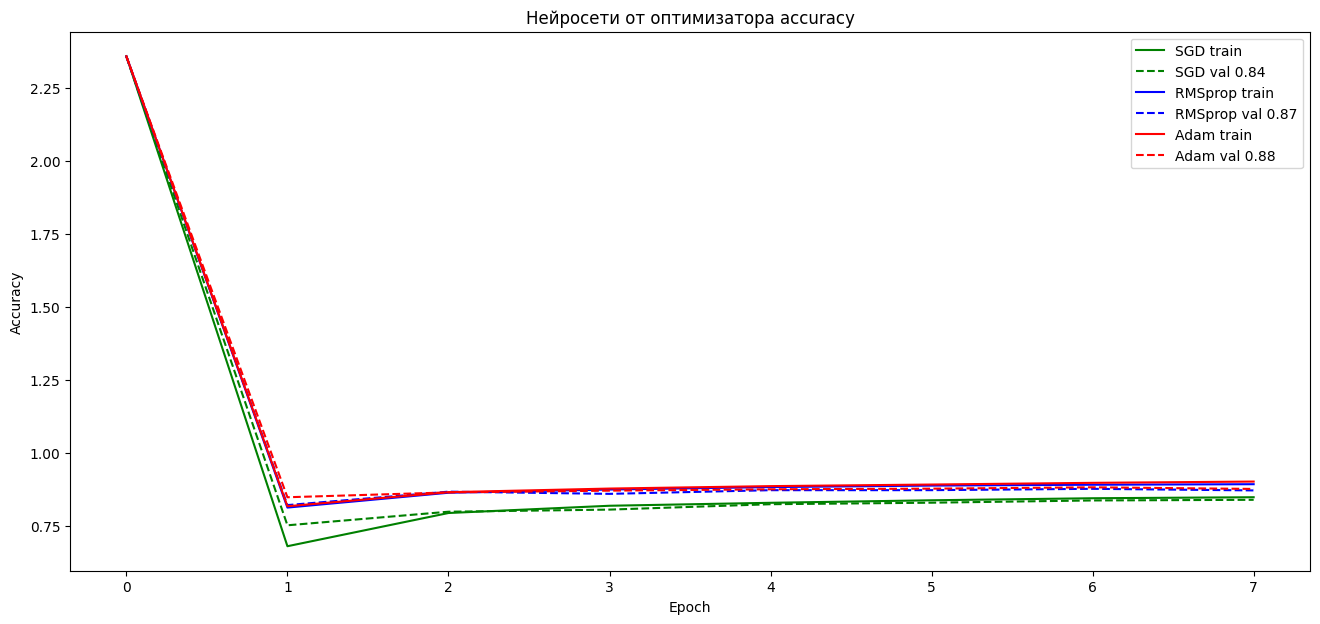

CPU times: total: 1min 47s
Wall time: 48.2 s


In [14]:
%%time

# создаем модель model
model = Sequential([
    Dense(64, activation='relu', input_shape=(28 * 28,)),
    Dense(512, activation='relu'),
    Dense(10, activation='sigmoid'),
])

# сохраняем ее веса (это начальная точка) model.save_weights('model.h5')
model.save_weights('model_weights.h5')

# будем сохранять модели в словарь
models = {}

plt.figure(figsize=(16, 7))
colors = ['g', 'b', 'r']

num_epochs = 7
batch_size = 64

# вектор для вывода результатов
epoch = np.arange(num_epochs+1)

# будем изменять оптимизаторы
for i, i_optim in enumerate([SGD(),
                             RMSprop(),
                             Adam()]):
    print(f'Оптимизатор: {i_optim.get_config()["name"]}')
    
    # создаем рабочую модель  model_i, куда будем загружать эти веса (она должна быть идентичной структуры)
    model_i = Sequential([
        Dense(64, activation='relu', input_shape=(28 * 28,)),
        Dense(512, activation='relu'),
        Dense(10, activation='sigmoid'),
    ])
    
    # загружаем веса model_i.load_weights('model.h5')
    model_i.load_weights('model_weights.h5')
    
    # компилируем model_i с одним из оптимизаторов
    model_i.compile(
        optimizer=i_optim,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )
    
    # вычисляем ошибку для modeli без обучения
    h0_train = model_i.evaluate(X_train, y_train, verbose=0)
    h0_val = model_i.evaluate(X_test, y_test, verbose=0)

    # проводим обучение модели 
    h = model_i.fit(X_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    verbose=1)
    
    # вычисляем ошибку для modeli после обучения
    loss, metric = model_i.evaluate(X_test, y_test, batch_size=64)
    print(f'Качество на тесте: {loss}, {metric}')
    
    # записываем обученную модель в словарь
    models[i_optim.get_config()['name']] = model_i

    
    # картинки
    '''
    plt.figure(figsize=(16, 7))
    plt.plot(epoch, np.log([h0_train[0]] + h.history['loss']),
             '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')
    plt.plot(epoch, np.log([h0_val[0]] + h.history['val_loss']),
             '--', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' val')
    '''
    
    plt.plot(epoch, ([h0_train[0]] + h.history['accuracy']),
             '-', c=colors[i],
             label=model_i.optimizer.get_config()['name'] + ' train')
    plt.plot(epoch, ([h0_val[0]] + h.history['val_accuracy']),
             '--', c=colors[i],
             label=f'{model_i.optimizer.get_config()["name"]} val {metric:.2f}')

plt.legend()
plt.title('Нейросети от оптимизатора accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Результаты

Итоговое качество на тестовой выборке получилось 0.88 благодаря подбору оптимального количества скрытых слоев (1) и количества нейронов на них (512), а также выбору оптимизатора (Adam). 

In [15]:
model_i = models['Adam']

In [16]:
model_i.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

1/1 [==============================] - 0s 75ms/step


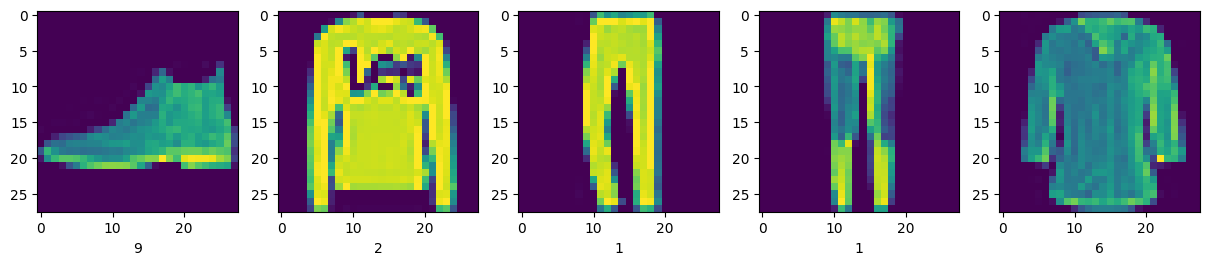

In [17]:
N = 5
y_pred = model_i.predict(X_test[:N, :])
y_pred_class = np.argmax(y_pred, axis=1)
plt.figure(figsize=(3 * N, 5))

for i in range(N):
  plt.subplot(1, N, i+1)
  plt.imshow(X_test[i,:].reshape(28, 28))
  #plt.xlabel(str(y_pred_class[i]))
  plt.xlabel(str(y_test_labels[i]))
plt.show() 

In [18]:
y_pred_class

array([9, 2, 1, 1, 6], dtype=int64)

In [19]:
y_pred = model_i.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

313/313 [==============================] - 0s 938us/step


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


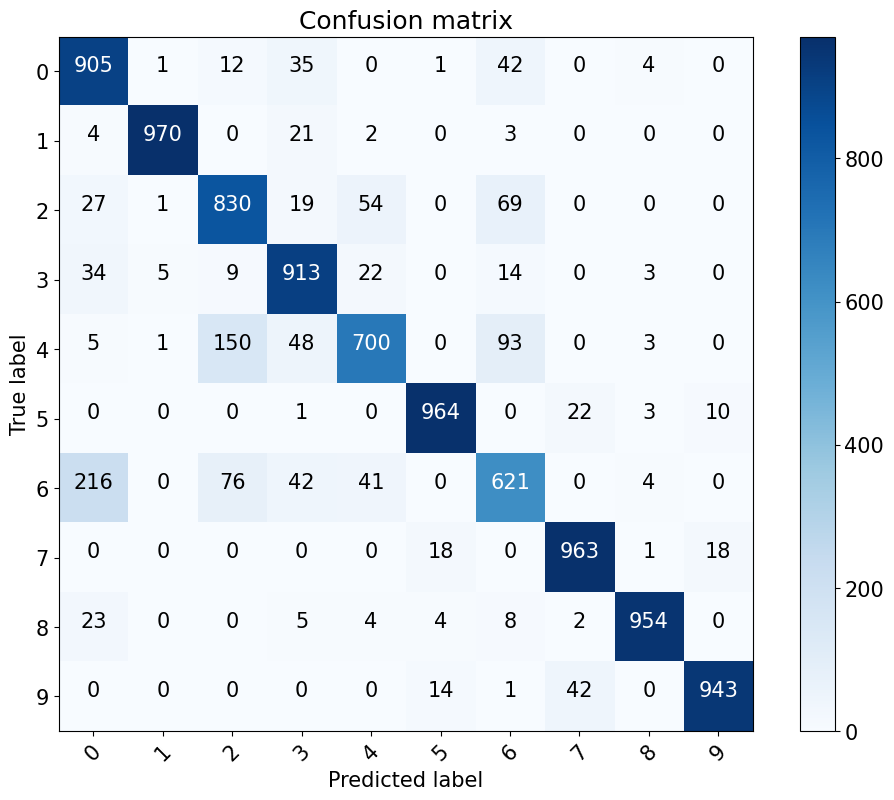

In [21]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_labels, y_pred_class)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                      title='Confusion matrix', normalize=False)
plt.show()

Модель часто путает 0 и 6 (футболки и рубашки) 2 и 4 (пуловер и пальто) 2 и 6 (пуловер и рубашки)

In [22]:
def get_precision_and_recall_from_confusion_matrix(label, cnf_matrix):
    str_sum = 0
    col_sum = 0
    for i in range(len(cnf_matrix)):
        str_sum += cnf_matrix[label][i]
        col_sum += cnf_matrix[i][label]
        
    return cnf_matrix[label][label] / str_sum, cnf_matrix[label][label] / col_sum

In [23]:
pr_rc_result = pd.DataFrame()
precisions = []
recalls = []
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
for l in labels:
    p_r = get_precision_and_recall_from_confusion_matrix(l, cnf_matrix)
    precisions.append(p_r[0])
    recalls.append(p_r[1])
pr_rc_result['label'] = labels
pr_rc_result['precision'] = precisions
pr_rc_result['recall'] = recalls

In [24]:
pr_rc_result.sort_values(by='precision', ascending=False)

,label,precision,recall
1,1,0.970,0.991820
5,5,0.964,0.963037
7,7,0.963,0.935860
8,8,0.954,0.981481
9,9,0.943,0.971164
3,3,0.913,0.842251
0,0,0.905,0.745470
2,2,0.830,0.770659
4,4,0.700,0.850547
6,6,0.621,0.729730


In [25]:
pr_rc_result.sort_values(by='recall', ascending=False)

,label,precision,recall
1,1,0.970,0.991820
8,8,0.954,0.981481
9,9,0.943,0.971164
5,5,0.964,0.963037
7,7,0.963,0.935860
4,4,0.700,0.850547
3,3,0.913,0.842251
2,2,0.830,0.770659
0,0,0.905,0.745470
6,6,0.621,0.729730


In [26]:
d = {0: 'Футболка/Клубка',
     1: 'Брюки',
     2: 'Пуловер',
     3: 'Платье',
     4: 'Пальто',
     5: 'Сандал',
     6: 'Рубашка',
     7: 'Кроссовок',
     8: 'Сумка',
     9: 'Ботинок'}

Получилось, что точнее всего наша модель предсказывает брюки, сандалии и сумки. Интересно, что кроссовки и ботинки тоже наверху списков, то есть модель их не путает. <br>
Хуже всего модель предсказывает футболки, пуловеры, пальто и рубашки. Их, видимо, проще спутать.

Посмотрим, ради интереса, на все представленные категории.

In [27]:
ind = []
for i in range(10):
    ind.append(np.where(y_test_labels == i)[0][0])

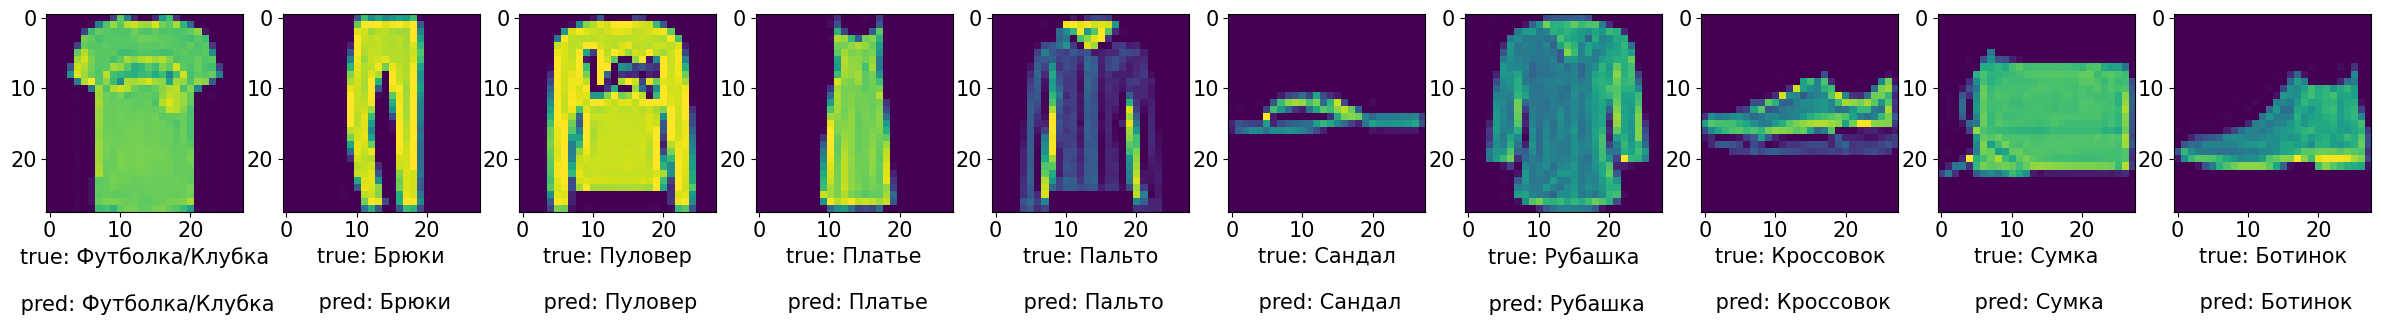

In [28]:
plt.figure(figsize=(3 * 10, 5))
k = 0
for i in ind:
    plt.subplot(1, 10, k+1)
    k+=1
    plt.imshow(X_test[i,:].reshape(28, 28))
    plt.xlabel('true: ' + str(d[y_test_labels[i]]) + '\n \n pred: ' + str(d[y_pred_class[i]]))

plt.show() 